In [1]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    GlueDataset,
    GlueDataTrainingArguments,
    Trainer,
    TrainingArguments,
    default_data_collator,
    glue_compute_metrics,
    glue_output_modes)
from influence_utils.utils_hans import HansDataset

import torch
import numpy as np
from tqdm import tqdm
from influence_utils.faiss_utils import FAISSIndex
from influence_utils.influence import compute_gradients
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from influence_utils.influence import compute_s_test
from influence_utils import glue_utils

In [2]:
tokenizer = AutoTokenizer.from_pretrained("/export/home/Experiments/20200706/")
model = AutoModelForSequenceClassification.from_pretrained("/export/home/Experiments/20200706/")
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased")
model.eval()

train_dataset = GlueDataset(
    args=GlueDataTrainingArguments(
        task_name="mnli",
        max_seq_length=128,
        data_dir="/export/home/Data/Glue/MNLI/"),
    tokenizer=tokenizer)

# eval_dataset = HansDataset(
#     data_dir="/export/home/Data/HANS/",
#     tokenizer=tokenizer,
#     task="hans",
#     max_seq_length=128,
#     overwrite_cache=False,
#     evaluate=True,
# )
eval_dataset = GlueDataset(
    args=GlueDataTrainingArguments(
        task_name="mnli",
        max_seq_length=128,
        data_dir="/export/home/Data/Glue/MNLI/"),
    tokenizer=tokenizer,
    mode="dev")

In [3]:
glue_utils.freeze_BERT_parameters(model)
model.training, model.device

Params Trainable: 14768643
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

(False, device(type='cpu'))

In [4]:
def custom_forward(
    model,
    input_ids=None,
    attention_mask=None,
    token_type_ids=None,
    position_ids=None,
    head_mask=None,
    inputs_embeds=None,
    labels=None,
    output_attentions=None,
    output_hidden_states=None,
    return_tuple=None,
):
    r"""
    labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`, defaults to :obj:`None`):
        Labels for computing the sequence classification/regression loss.
        Indices should be in :obj:`[0, ..., config.num_labels - 1]`.
        If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
        If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
    """
    if model.training is True:
        raise ValueError

    outputs = model.bert(
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
    )

    pooled_output = outputs[1]

    return model.dropout(pooled_output)


def hans_data_collator(features):
    """
    Data collator that removes the "pairID" key if present.
    """
    batch = default_data_collator(features)
    _ = batch.pop("pairID", None)
    return batch


def get_dataloader(dataset, batch_size, data_collator) -> DataLoader:
    sampler = SequentialSampler(dataset)

    data_loader = DataLoader(
        dataset,
        sampler=sampler,
        batch_size=batch_size,
        collate_fn=data_collator,
    )

    return data_loader


def decode_one_example(inputs, logits=None):
    if inputs["input_ids"].shape[0] != 1:
        raise ValueError

    X = tokenizer.decode(inputs["input_ids"][0])
    Y = train_dataset.label_list[inputs["labels"].item()]
    if logits is not None:
        Y_hat = train_dataset.label_list[
            logits.argmax(dim=-1).item()]
        return X, Y, Y_hat
    else:
        return X, Y

output_mode = glue_output_modes["mnli"]
def build_compute_metrics_fn(task_name: str):
    def compute_metrics_fn(p):
        if output_mode == "classification":
            preds = np.argmax(p.predictions, axis=1)
        elif output_mode == "regression":
            preds = np.squeeze(p.predictions)
        return glue_compute_metrics(task_name, preds, p.label_ids)

    return compute_metrics_fn


trainer = Trainer(
    model=model,
    args=TrainingArguments(output_dir="./tmp-output", per_device_train_batch_size=128, per_device_eval_batch_size=128, learning_rate=5e-5, logging_steps=100),
    data_collator=hans_data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=build_compute_metrics_fn("mnli"),
)

train_batch_data_loader = get_dataloader(
    train_dataset,
    batch_size=160,
    data_collator=hans_data_collator)

train_instance_data_loader = get_dataloader(
    train_dataset,
    batch_size=1,
    data_collator=hans_data_collator)

eval_instance_data_loader = get_dataloader(
    eval_dataset,
    batch_size=1,
    data_collator=hans_data_collator)


def run_forward(model, inputs):
    # Implicitly used trainer and model
    has_labels = any(inputs.get(k) is not None for k in ["labels", "lm_labels", "masked_lm_labels"])

    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            inputs[k] = v.to(trainer.args.device)
    if trainer.args.past_index >= 0:
        inputs["mems"] = past

    with torch.no_grad():
        outputs = model(**inputs)
        if has_labels:
            step_eval_loss, logits = outputs[:2]
            return step_eval_loss, logits
        else:
            logits = outputs[0]
            return logits
        
        
def visualize(inputs):
    X, Y = decode_one_example(inputs)
    premise, hypothesis = X.split("[CLS]")[1].split("[SEP]")[:2]
    print(f"\tP: {premise.strip()}\n\tH: {hypothesis.strip()}\n\tL: {Y}")

You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


wandb: Wandb version 0.9.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
for i, test_inputs in enumerate(eval_instance_data_loader):
    step_eval_loss, logits = run_forward(model, test_inputs)
    if i > 40 and (test_inputs["labels"] != logits.argmax(dim=1)).item():
        break

In [6]:
i

41

In [7]:
decode_one_example(test_inputs, logits)

("[CLS] What's truly striking, though, is that Jobs has never really let this idea go. [SEP] Jobs never held onto an idea for long. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",
 'contradiction',
 'entailment')

In [8]:
visualize(test_inputs)

	P: What's truly striking, though, is that Jobs has never really let this idea go.
	H: Jobs never held onto an idea for long.
	L: contradiction


In [9]:
params_filter = None
weight_decay_ignores = None
weight_decay = 0.005
weight_decay_ignores = None
if params_filter is None:
    params_filter = [
        "bert.pooler.dense.weight",
        "bert.pooler.dense.bias"] + [
        n for n, p in model.named_parameters()
        if not p.requires_grad]

# We actually included `bert.pooler.dense.*`
# but this should be fine? Because the gradients
# of these parameters are not included anyway.
if weight_decay_ignores is None:
    weight_decay_ignores = [
        "bias",
        "LayerNorm.weight"] + [
        n for n, p in model.named_parameters()
        if not p.requires_grad]

# s_test = compute_s_test(
#     n_gpu=1,
#     device=torch.device("cuda"),
#     model=model,
#     test_inputs=test_inputs,
#     train_data_loaders=[train_batch_data_loader],
#     params_filter=params_filter,
#     weight_decay=weight_decay,
#     weight_decay_ignores=weight_decay_ignores,
#     scale=1000,
#     num_samples=300)

In [10]:
faiss_index = FAISSIndex(768, "Flat")
faiss_index.load("/export/home/Experiments/20200713/MNLI.index")
# torch.save(s_test, "/export/home/Experiments/20200711/s_test.tmp.mnli-56")
s_test = torch.load("/export/home/Experiments/20200706/s_test.tmp.mnli-3")

len(faiss_index)

392702

In [85]:
test_features = custom_forward(model, **test_inputs)
test_features = test_features.cpu().detach().numpy()
KNN_distances, KNN_indices = faiss_index.search(k=1000, queries=test_features)
# indices = set(indices.squeeze(axis=0).tolist())

In [86]:
# indices.squeeze(axis=0)[np.argsort(distances.squeeze(axis=0))[-1]]
KNN_distances[(KNN_indices.squeeze(axis=0)[np.argsort(KNN_distances.squeeze(axis=0))] != KNN_indices)]

array([], dtype=float32)

In [87]:
max_influence = 0.00
influences = {}
train_inputs_collections = {}
with tqdm(train_instance_data_loader) as pbar:
    for index, train_inputs in enumerate(pbar):
        if index not in KNN_indices:
            continue

        grad_z = compute_gradients(
            n_gpu=1,
            device=torch.device("cuda"),
            model=model,
            inputs=train_inputs,
            params_filter=params_filter,
            weight_decay=weight_decay,
            weight_decay_ignores=weight_decay_ignores)

        # experimental_clip_gradient_norm_(grad_z, max_norm=1.0)
        with torch.no_grad():
            influence = [
                - torch.sum(x * y)
                for x, y in zip(grad_z, s_test)]

            if sum(influence).item() > max_influence:
                max_influence = sum(influence).item()
                visualize(train_inputs)
                print(max_influence)

        influences[index] = sum(influence).item()
        train_inputs_collections[index] = train_inputs

  0%|          | 1665/392702 [00:00<00:48, 8069.07it/s]

	P: Thus, with respect to the litigation services Congress has funded, there is no alternative channel for expression of the advocacy Congress seeks to restrict.
	H: This is the only channel of expression of the advocacy that Congress seeks to restrict.
	L: entailment
0.02001420222222805
	P: It is impossible to draw a bright line between ultimate fighting and boxing.
	H: The differences between ultimate fighting and boxing are few.
	L: entailment
0.02754782699048519
	P: Nonetheless, becoming more efficient is not enough to remain competitive.
	H: Success doesn't result from simply being more efficient.
	L: entailment
0.0823083147406578


  1%|▏         | 5781/392702 [00:00<00:37, 10260.96it/s]

	P: Although the bed dates from the 1680s, it has never been slept in by royalty.
	H: No one of royal blood had ever slept on the bed.
	L: entailment
0.2622215449810028


100%|██████████| 392702/392702 [00:36<00:00, 10640.51it/s]


In [88]:
# influences = torch.load("/export/home/Experiments/20200706/influences.tmp.pt.full")
# train_inputs_collections = torch.load("/export/home/Experiments/20200706/train_inputs_collections.tmp.pt.full")

In [89]:
# np.argsort(influences)[-20:], np.array(influences)[np.argsort(influences)][-20:]

In [16]:
# np.argsort(influences)[:20], np.array(influences)[np.argsort(influences)][:20]

In [17]:
# print("Top 3 Influential (harmful)")
# visualize(train_inputs_collections[201907])
# print()
# visualize(train_inputs_collections[140485])
# print()
# visualize(train_inputs_collections[102963])

In [18]:
# print("Top 3 Influential (helpful)")
# visualize(train_inputs_collections[58075])
# print()
# visualize(train_inputs_collections[9102])
# print()
# visualize(train_inputs_collections[153048])

In [90]:
most_harmful = sorted(influences.items(), key=lambda p: p[1])[-1]
most_helpful = sorted(influences.items(), key=lambda p: p[1])[0]
most_helpful, most_harmful

((27036, -0.5494213700294495), (2869, 0.2622215449810028))

In [91]:
from copy import deepcopy
import matplotlib.pyplot as plt

In [57]:
params_to_freeze = [
    "bert.embeddings.",
    "bert.encoder.layer.0.",
    "bert.encoder.layer.1.",
    "bert.encoder.layer.2.",
    "bert.encoder.layer.3.",
    "bert.encoder.layer.4.",
    "bert.encoder.layer.5.",
    "bert.encoder.layer.6.",
    "bert.encoder.layer.7.",
    "bert.encoder.layer.8.",
    "bert.encoder.layer.9.",
] + [
    "bert.pooler.dense.weight",
    "bert.pooler.dense.bias"]

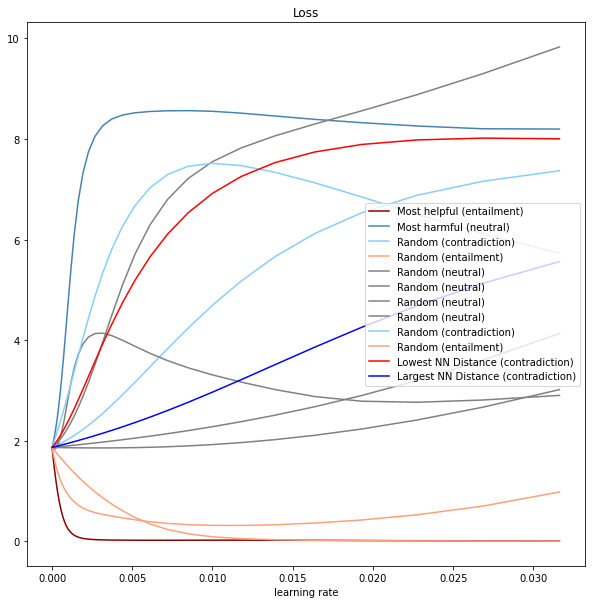

In [83]:
plt.rcParams["figure.figsize"] = (10, 10)
for j, c in zip(# [58075, 201907, 134448, 192584, 275967, 381952, 361464, 179400, 177993, 114332],
                [129406, 146949, 134448, 192584, 275967, 381952, 361464, 179400, 177993, 114332, 289717, 132860],
                ["darkred", "steelblue", "lightskyblue", "lightsalmon", "grey", "grey", "grey", "grey", "lightskyblue", "lightsalmon", "red", "blue"]):

    learning_rates = np.logspace(-5, -1.5, 50)
    helpful_grad_z = compute_gradients(
        n_gpu=1,
        device=torch.device("cuda"),
        model=model,
        inputs=train_inputs_collections[j],
        params_filter=params_filter,
        weight_decay=weight_decay,
        weight_decay_ignores=weight_decay_ignores)

    step_eval_losses = []
    for lr in learning_rates:
        new_model = deepcopy(model)
        params_to_update = [p for name, p in new_model.named_parameters()
                            if not any(pfreeze in name for pfreeze in params_to_freeze)]
        with torch.no_grad():
            [p.sub_(lr * grad_z) for p, grad_z in zip(params_to_update, helpful_grad_z)]

        step_eval_loss, logits = run_forward(new_model, test_inputs)
        step_eval_losses.append(step_eval_loss)

    plt.plot(learning_rates, step_eval_losses, color=c)
plt.legend(["Most helpful (entailment)",
            "Most harmful (neutral)",
            "Random (contradiction)",
            "Random (entailment)",
            "Random (neutral)",
            "Random (neutral)",
            "Random (neutral)",
            "Random (neutral)",
            "Random (contradiction)",
            "Random (entailment)",
            "Lowest NN Distance (contradiction)",
            "Largest NN Distance (contradiction)"])
plt.xlabel("learning rate")
plt.title("Loss")
# plt.savefig("./20200713-fig1.pdf")

In [59]:
train_dataset.label_list

['contradiction', 'entailment', 'neutral']

In [342]:
np.random.randint(len(train_inputs_collections))

114332

In [363]:
step_eval_loss, logits = run_forward(model, test_inputs)
decode_one_example(test_inputs, logits)
logits.softmax(dim=-1), step_eval_loss

(tensor([[0.0848, 0.7960, 0.1192]], device='cuda:0'),
 tensor(2.4675, device='cuda:0'))

In [358]:
step_eval_loss, logits = run_forward(new_model, test_inputs)
decode_one_example(test_inputs, logits)

("[CLS] What's truly striking, though, is that Jobs has never really let this idea go. [SEP] Jobs never held onto an idea for long. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",
 'contradiction',
 'entailment')

In [92]:
with open("/export/home/Data/Glue/MNLI/train.tsv") as f:
    lines = f.readlines()

In [93]:
# sorted_influences = np.argsort(influences)
most_harmful = [p[0] for p in sorted(influences.items(), key=lambda p: p[1])][::-1]
most_helpful = [p[0] for p in sorted(influences.items(), key=lambda p: p[1])]
smallest_distance = KNN_indices.squeeze(axis=0).tolist()
train_dataset.label_list

['contradiction', 'entailment', 'neutral']

In [94]:
# contradiction_indices = [i for i, d in enumerate(train_inputs_collections) if d["labels"].item() == 0]
# entailment_indices = [i for i, d in enumerate(train_inputs_collections) if d["labels"].item() == 1]
# neutral_indices = [i for i, d in enumerate(train_inputs_collections) if d["labels"].item() == 2]

In [95]:
# np.argsort(influences)[-20:]
# most_helpful[-100:][::-1] == most_harmful[:100]
most_helpful[:10], most_harmful[:10]

([27036, 162804, 197547, 317492, 179957, 2774, 368576, 28457, 272004, 97813],
 [2869, 50388, 123908, 207378, 275023, 231785, 264879, 99877, 95952, 93177])

In [96]:
import os
for num in [1, 20, 100]:
# for num in [1000, 3000]:
#     random_dir_name = f"./MNLI_data/remove_{num}_random/"
#     harmful_dir_name = f"./MNLI_data/remove_{num}_harmful/"
#     helpful_dir_name = f"./MNLI_data/remove_{num}_helpful/"
    harmful_dir_name = f"./MNLI_data/remove_{num}_harmful_1000/"
    helpful_dir_name = f"./MNLI_data/remove_{num}_helpful_1000/"
#     harmful_dir_name = f"./MNLI_data/remove_{num}_harmful_10000/"
#     helpful_dir_name = f"./MNLI_data/remove_{num}_helpful_10000/"
    smallest_distance_dir_name = f"./MNLI_data/remove_{num}_smallest_distance_1000/"
#     smallest_distance_dir_name = f"./MNLI_data/remove_{num}_smallest_distance_10000/"
#     random_contradiction_dir_name = f"./MNLI_data/remove_{num}_random_contradiction/"
#     random_entailment_dir_name = f"./MNLI_data/remove_{num}_random_entailment/"
#     random_neutral_dir_name = f"./MNLI_data/remove_{num}_random_neutral/"

#     random_indices = np.random.choice(
#         len(influences), size=num, replace=False)
#     harmful_indices = sorted_influences[-num:]
#     helpful_indices = sorted_influences[:num]
    harmful_indices = most_harmful[:num]
    helpful_indices = most_helpful[:num]
    smallest_distance_indices = smallest_distance[:num]
#     random_contradiction_indices = np.random.choice(
#         contradiction_indices, size=num, replace=False)
#     random_entailment_indices = np.random.choice(
#         entailment_indices, size=num, replace=False)
#     random_neutral_indices = np.random.choice(
#         neutral_indices, size=num, replace=False)

    
    for dir_name, indices in zip([
                                  # random_dir_name,
                                  harmful_dir_name,
                                  helpful_dir_name,
                                  # random_contradiction_dir_name,
                                  # random_entailment_dir_name,
                                  # random_neutral_dir_name,
                                  smallest_distance_dir_name,
                                 ],
                                 [
                                  # random_indices,
                                  harmful_indices,
                                  helpful_indices,
                                  # random_contradiction_indices,
                                  # random_entailment_indices,
                                  # random_neutral_indices,
                                  smallest_distance_indices,
                                 ]):
        if not os.path.isdir(dir_name):
            os.makedirs(dir_name)
        else:
            raise ValueError

        with open(os.path.join(dir_name, "train.tsv"), "w") as f:
            lines_to_write = [
                # "-1" because of the header line
                l for i, l in enumerate(lines)
                if i - 1 not in indices]

            f.write("".join(lines_to_write))
            print(f"Wrote {len(lines_to_write)} to {dir_name}")

        # Sanity checks
#         print(dir_name)
#         lines_to_remove = [
#             # "-1" because of the header line
#             l for i, l in enumerate(lines)
#             if i - 1 in indices]
#         print("\n\t".join(["     ".join(l.split("\t")[-4:-2]) for l in lines_to_remove][:1]))
#         print("")

Wrote 392702 to ./MNLI_data/remove_1_harmful_1000/
Wrote 392702 to ./MNLI_data/remove_1_helpful_1000/
Wrote 392702 to ./MNLI_data/remove_1_smallest_distance_1000/
Wrote 392683 to ./MNLI_data/remove_20_harmful_1000/
Wrote 392683 to ./MNLI_data/remove_20_helpful_1000/
Wrote 392683 to ./MNLI_data/remove_20_smallest_distance_1000/
Wrote 392603 to ./MNLI_data/remove_100_harmful_1000/
Wrote 392603 to ./MNLI_data/remove_100_helpful_1000/
Wrote 392603 to ./MNLI_data/remove_100_smallest_distance_1000/
